# **Facial Emotion Recognition**


In [199]:
import os
import random
import cv2
from pathlib import Path
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
# dataset import
base_dir = r"C:\Users\ashis\OneDrive\Desktop\Facial Emotion Recognition\\facial_dataset" 
train_counts = {cls: len(os.listdir(Path(base_dir) / "train" / cls)) for cls in os.listdir(Path(base_dir) / "train")}
test_counts = {cls: len(os.listdir(Path(base_dir) / "test" / cls)) for cls in os.listdir(Path(base_dir) / "test")}



In [ ]:
dataset_path = Path(base_dir)
if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset root not found: {base_dir}")

print("\nDataset root exists. Listing top-level folders:")
for p in sorted(dataset_path.iterdir()):
    print(" -", p.name)

# train, test folder
train_dir = dataset_path / "train"
test_dir = dataset_path / "test"
if not train_dir.exists() or not test_dir.exists():
    print("\nWarning: One of 'train' or 'test' folders not found.")
    print("Contents of dataset root:")
    for p in sorted(dataset_path.iterdir()):
        print(" -", p.name)
else:
    print("\nFound both 'train' and 'test' folders.")



Dataset root exists. Listing top-level folders:
 - test
 - train

Found both 'train' and 'test' folders.


In [ ]:
# count images
def count_images_in_dir(folder):
    counts = {}
    for cls in sorted([d for d in folder.iterdir() if d.is_dir()]):
        files = [f for f in cls.iterdir() if f.is_file()]
        counts[cls.name] = len(files)
    return counts

print("\nTrain counts (per class):")
if train_dir.exists():
    train_counts = count_images_in_dir(train_dir)
    for k,v in train_counts.items():
        print(f"  {k}: {v}")
else:
    train_counts = {}

print("\nTest counts (per class):")
if test_dir.exists():
    test_counts = count_images_in_dir(test_dir)
    for k,v in test_counts.items():
        print(f"  {k}: {v}")
else:
    test_counts = {}


Train counts (per class):
  angry: 3995
  disgusted: 436
  fearful: 4097
  happy: 7215
  neutral: 4965
  sad: 4830
  surprised: 3171

Test counts (per class):
  angry: 958
  disgusted: 111
  fearful: 1024
  happy: 1774
  neutral: 1233
  sad: 1247
  surprised: 831


In [ ]:
# Iterate through train and test folders
for folder, counts in (("train", train_counts), ("test", test_counts)):
    for cls, cnt in counts.items():
        if cnt > 0:
            # Get the first image from the folder
            folder_path = Path(base_dir) / folder / cls
            images = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
            
            if not images:
                sample_info[f"{folder}/{cls}"] = {"error": "No image files found"}
                continue

            sample_path = folder_path / images[0]
            try:
                im = Image.open(sample_path)
                sample_info[f"{folder}/{cls}"] = {
                    "path": str(sample_path),
                    "mode": im.mode,      
                    "size": im.size,      
                    "format": im.format   
                }
            except Exception as e:
                sample_info[f"{folder}/{cls}"] = {"error": str(e)}

In [ ]:
# train, test directories path
train_dir = "C:\\Users\\ashis\\OneDrive\\Desktop\\Facial Emotion Recognition\\facial_dataset\\train"
test_dir = "C:\\Users\\ashis\\OneDrive\\Desktop\\Facial Emotion Recognition\\facial_dataset\\test"

# processing
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    zoom_range=0.2,          
    horizontal_flip=True     
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

# load test images
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [205]:
print("Class Labels:", train_generator.class_indices)


Class Labels: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


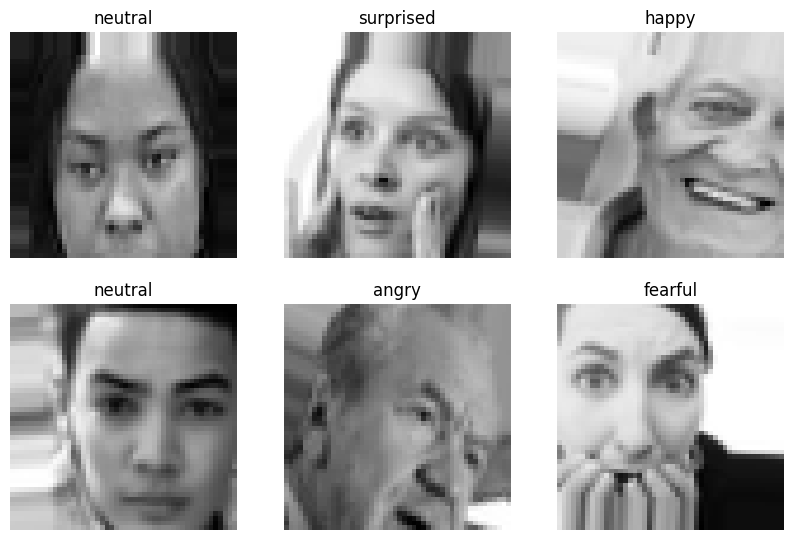

In [284]:
images, labels = next(train_generator)

# Display sample images
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(48, 48), cmap='gray')
    plt.title(list(train_generator.class_indices.keys())[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

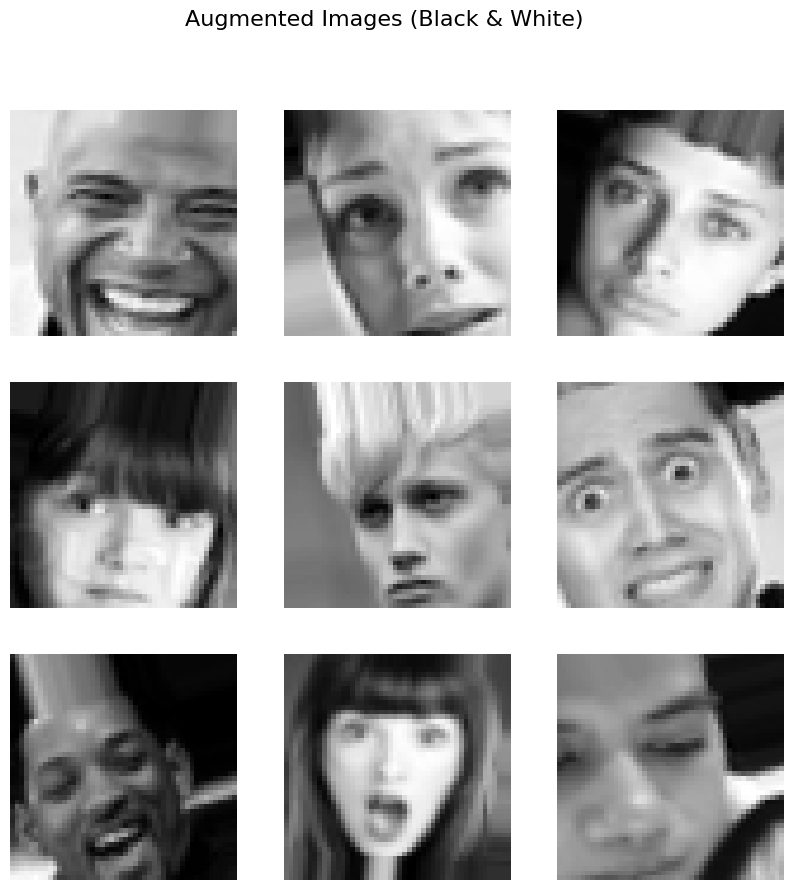

In [285]:
img, label = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[i].reshape(48, 48), cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Images (Black & White)", fontsize=16)
plt.show()


In [ ]:

model = Sequential()

#layer1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#layer2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#layer3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# falteen and fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#output layer
model.add(Dense(train_generator.num_classes, activation='softmax'))  # one output per emotion class

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\ashis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,255 (1.36 MB)

 Trainable params: 356,551 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# sve the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# stop training if no improvement for 5 epochs
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
epochs = 40
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[checkpoint, reduce_lr, early_stop]
)

Epoch 1/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.1843 - loss: 2.4498
Epoch 1: val_accuracy improved from None to 0.25202, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 321s 703ms/step - accuracy: 0.2073 - loss: 2.1764 - val_accuracy: 0.2520 - val_loss: 1.8376 - learning_rate: 0.0010
Epoch 2/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.2626 - loss: 1.8356
Epoch 2: val_accuracy improved from 0.25202 to 0.26637, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 80s 178ms/step - accuracy: 0.2716 - loss: 1.8008 - val_accuracy: 0.2664 - val_loss: 1.7934 - learning_rate: 0.0010
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3017 - loss: 1.7422
Epoch 3: val_accuracy improved from 0.26637 to 0.33324, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 171ms/step - accuracy: 0.3058 - loss: 1.7279 - val_accuracy: 0.3332 - val_loss: 1.6300 - learning_rate: 0.0010
Epoch 4/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3300 - loss: 1.6785
Epoch 4: val_accuracy improved from 0.33324 to 0.40554, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.3389 - loss: 1.6639 - val_accuracy: 0.4055 - val_loss: 1.5412 - learning_rate: 0.0010
Epoch 5/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.3608 - loss: 1.6256
Epoch 5: val_accuracy improved from 0.40554 to 0.45444, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 173ms/step - accuracy: 0.3680 - loss: 1.6103 - val_accuracy: 0.4544 - val_loss: 1.4501 - learning_rate: 0.0010
Epoch 6/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3789 - loss: 1.5786
Epoch 6: val_accuracy did not improve from 0.45444
449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 170ms/step - accuracy: 0.3818 - loss: 1.5723 - val_accuracy: 0.4433 - val_loss: 1.4467 - learning_rate: 0.0010
Epoch 7/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3970 - loss: 1.5490
Epoch 7: val_accuracy improved from 0.45444 to 0.45793, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 169ms/step - accuracy: 0.4029 - loss: 1.5360 - val_accuracy: 0.4579 - val_loss: 1.4155 - learning_rate: 0.0010
Epoch 8/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4112 - loss: 1.5134
Epoch 8: val_accuracy improved from 0.45793 to 0.47813, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 170ms/step - accuracy: 0.4122 - loss: 1.5076 - val_accuracy: 0.4781 - val_loss: 1.3692 - learning_rate: 0.0010
Epoch 9/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4150 - loss: 1.5076
Epoch 9: val_accuracy improved from 0.47813 to 0.48593, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 175ms/step - accuracy: 0.4222 - loss: 1.4938 - val_accuracy: 0.4859 - val_loss: 1.3351 - learning_rate: 0.0010
Epoch 10/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4245 - loss: 1.4765
Epoch 10: val_accuracy did not improve from 0.48593
449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 170ms/step - accuracy: 0.4301 - loss: 1.4727 - val_accuracy: 0.4645 - val_loss: 1.3926 - learning_rate: 0.0010
Epoch 11/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4348 - loss: 1.4729
Epoch 11: val_accuracy improved from 0.48593 to 0.51310, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 171ms/step - accuracy: 0.4412 - loss: 1.4561 - val_accuracy: 0.5131 - val_loss: 1.2977 - learning_rate: 0.0010
Epoch 12/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4432 - loss: 1.4513
Epoch 12: val_accuracy improved from 0.51310 to 0.51686, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 171ms/step - accuracy: 0.4447 - loss: 1.4487 - val_accuracy: 0.5169 - val_loss: 1.2675 - learning_rate: 0.0010
Epoch 13/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4550 - loss: 1.4242
Epoch 13: val_accuracy improved from 0.51686 to 0.52048, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.4546 - loss: 1.4244 - val_accuracy: 0.5205 - val_loss: 1.2763 - learning_rate: 0.0010
Epoch 14/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4511 - loss: 1.4245
Epoch 14: val_accuracy did not improve from 0.52048
449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.4564 - loss: 1.4174 - val_accuracy: 0.4992 - val_loss: 1.3069 - learning_rate: 0.0010
Epoch 15/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4573 - loss: 1.4115
Epoch 15: val_accuracy did not improve from 0.52048
449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.4617 - loss: 1.4063 - val_accuracy: 0.5089 - val_loss: 1.2770 - learning_rate: 0.0010
Epoch 16/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4655 - loss: 1.3990
Epoch 16: val_accuracy did not improve from 0.52048

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.4658 - lo

449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 173ms/step - accuracy: 0.4774 - loss: 1.3694 - val_accuracy: 0.5458 - val_loss: 1.1827 - learning_rate: 5.0000e-04
Epoch 18/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4808 - loss: 1.3670
Epoch 18: val_accuracy did not improve from 0.54583
449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.4812 - loss: 1.3630 - val_accuracy: 0.5453 - val_loss: 1.1763 - learning_rate: 5.0000e-04
Epoch 19/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4829 - loss: 1.3575
Epoch 19: val_accuracy improved from 0.54583 to 0.55698, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.4822 - loss: 1.3535 - val_accuracy: 0.5570 - val_loss: 1.1615 - learning_rate: 5.0000e-04
Epoch 20/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.4942 - loss: 1.3366
Epoch 20: val_accuracy improved from 0.55698 to 0.56199, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 174ms/step - accuracy: 0.4899 - loss: 1.3451 - val_accuracy: 0.5620 - val_loss: 1.1496 - learning_rate: 5.0000e-04
Epoch 21/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.4829 - loss: 1.3493
Epoch 21: val_accuracy did not improve from 0.56199
449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 174ms/step - accuracy: 0.4879 - loss: 1.3453 - val_accuracy: 0.5619 - val_loss: 1.1408 - learning_rate: 5.0000e-04
Epoch 22/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.4926 - loss: 1.3223
Epoch 22: val_accuracy did not improve from 0.56199
449/449 ━━━━━━━━━━━━━━━━━━━━ 165s 367ms/step - accuracy: 0.4908 - loss: 1.3318 - val_accuracy: 0.5535 - val_loss: 1.1653 - learning_rate: 5.0000e-04
Epoch 23/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.4875 - loss: 1.3401
Epoch 23: val_accuracy did not improve from 0.56199

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
449/449 ━━━━━━━━━━━━━━━━━━━━ 80s 178ms/step - accuracy

449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 174ms/step - accuracy: 0.5020 - loss: 1.3136 - val_accuracy: 0.5649 - val_loss: 1.1223 - learning_rate: 2.5000e-04
Epoch 25/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5014 - loss: 1.3122
Epoch 25: val_accuracy did not improve from 0.56492
449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 174ms/step - accuracy: 0.5020 - loss: 1.3138 - val_accuracy: 0.5631 - val_loss: 1.1386 - learning_rate: 2.5000e-04
Epoch 26/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5067 - loss: 1.3002
Epoch 26: val_accuracy improved from 0.56492 to 0.56548, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 174ms/step - accuracy: 0.5009 - loss: 1.3119 - val_accuracy: 0.5655 - val_loss: 1.1291 - learning_rate: 2.5000e-04
Epoch 27/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5029 - loss: 1.3065
Epoch 27: val_accuracy did not improve from 0.56548
449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 176ms/step - accuracy: 0.5094 - loss: 1.3011 - val_accuracy: 0.5646 - val_loss: 1.1276 - learning_rate: 2.5000e-04
Epoch 28/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5021 - loss: 1.2944
Epoch 28: val_accuracy improved from 0.56548 to 0.57133, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 177ms/step - accuracy: 0.5016 - loss: 1.3055 - val_accuracy: 0.5713 - val_loss: 1.1048 - learning_rate: 2.5000e-04
Epoch 29/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4995 - loss: 1.3005
Epoch 29: val_accuracy improved from 0.57133 to 0.57161, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 177ms/step - accuracy: 0.5022 - loss: 1.2973 - val_accuracy: 0.5716 - val_loss: 1.1239 - learning_rate: 2.5000e-04
Epoch 30/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5023 - loss: 1.3010
Epoch 30: val_accuracy improved from 0.57161 to 0.57927, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 177ms/step - accuracy: 0.5040 - loss: 1.3004 - val_accuracy: 0.5793 - val_loss: 1.1081 - learning_rate: 2.5000e-04
Epoch 31/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5116 - loss: 1.2831
Epoch 31: val_accuracy did not improve from 0.57927
449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 177ms/step - accuracy: 0.5092 - loss: 1.2911 - val_accuracy: 0.5613 - val_loss: 1.1506 - learning_rate: 2.5000e-04
Epoch 32/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5094 - loss: 1.2858
Epoch 32: val_accuracy did not improve from 0.57927
449/449 ━━━━━━━━━━━━━━━━━━━━ 80s 177ms/step - accuracy: 0.5093 - loss: 1.2891 - val_accuracy: 0.5536 - val_loss: 1.1575 - learning_rate: 2.5000e-04
Epoch 33/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5110 - loss: 1.2905
Epoch 33: val_accuracy did not improve from 0.57927

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 175ms/step - accuracy:

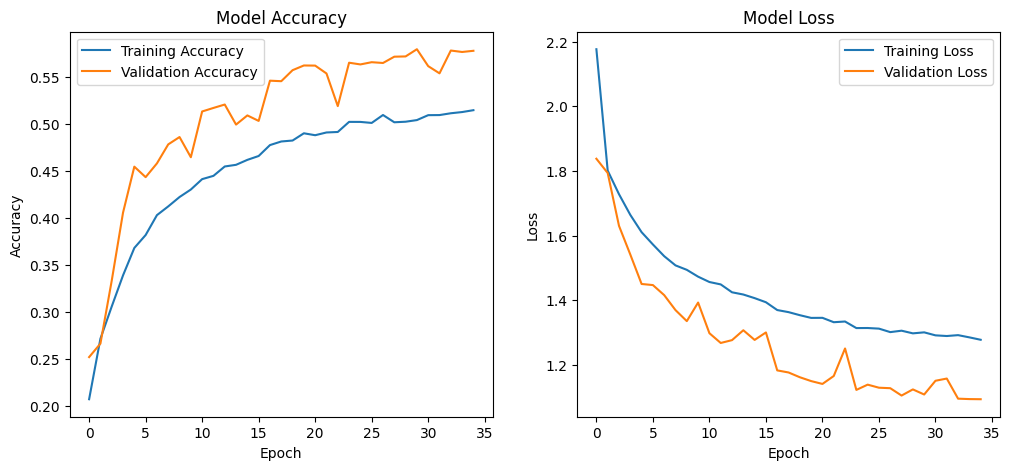

In [219]:

# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
#save model
model.save("final_emotion_model.h5")


In [ ]:
# accuracy
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.5793 - loss: 1.1081
Test Accuracy: 57.93%
Test Loss: 1.1081


In [287]:
# Prediction
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print("Classification Report:\n")
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))



113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step
Classification Report:

              precision    recall  f1-score   support

       angry       0.44      0.58      0.50       958
   disgusted       0.67      0.02      0.04       111
     fearful       0.48      0.13      0.20      1024
       happy       0.79      0.84      0.81      1774
     neutral       0.48      0.67      0.56      1233
         sad       0.48      0.41      0.44      1247
   surprised       0.67      0.78      0.72       831

    accuracy                           0.58      7178
   macro avg       0.57      0.49      0.47      7178
weighted avg       0.58      0.58      0.55      7178



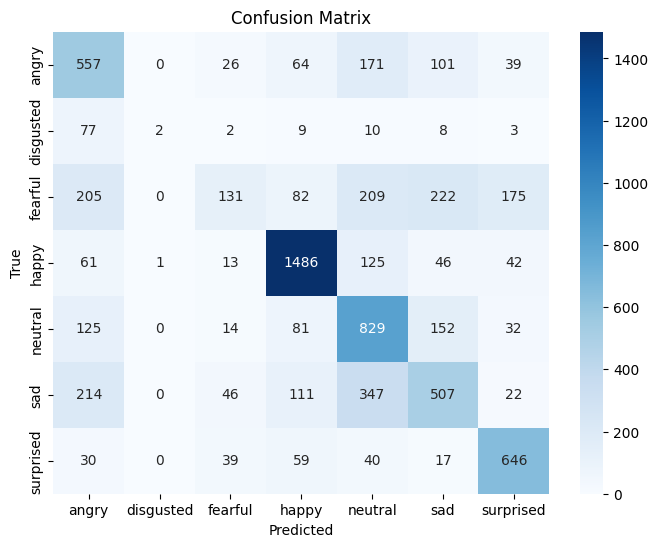

In [286]:
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [288]:
# load model for prediction on new data
model = load_model('final_emotion_model.h5')
emotion_labels = list(train_generator.class_indices.keys())

print("Model loaded")
print("Emotion Labels:", emotion_labels)





Model loaded
Emotion Labels: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [295]:
# test model on new image
image_path = "C:\\Users\\ashis\\OneDrive\\Desktop\\Facial Emotion Recognition\\images\\happy_face.png"
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(" Image loaded")

 Image loaded


In [296]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

faces = face_classifier.detectMultiScale(gray, 1.3, 5)
print(f" Detected {len(faces)} face(s) in the image.")

 Detected 1 face(s) in the image.


In [297]:

for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    roi_gray = gray[y:y+h, x:x+w]
    roi_gray = cv2.resize(roi_gray, (48, 48))
    roi = roi_gray.astype('float') / 255.0
    roi = np.expand_dims(roi, axis=-1) 
    roi = np.expand_dims(roi, axis=0)  
    
    preds = model.predict(roi)[0]
    label = emotion_labels[np.argmax(preds)]
    confidence = np.max(preds)
    
    label_text = f"{label} ({confidence*100:.1f}%)"
    cv2.putText(image, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (0, 255, 0), 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [298]:
#show output
cv2.imshow("Emotion Detection", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
